In [12]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [13]:
def load_hdf5_to_dict(hdf5_file, group_name=''):
    """
    Legge un file HDF5 salvato dal codice specificato e salva tutto il contenuto in un dizionario.

    :param hdf5_file: percorso al file HDF5
    :param group_name: nome del gruppo da cui iniziare la lettura, se presente
    :return: un dizionario con i dati del file HDF5
    """
    def recursively_load_group_to_dict(h5group):
        dictionary = {}
        for key, item in h5group.items():
            if isinstance(item, h5py.Dataset):
                dictionary[key] = item[()]
            elif isinstance(item, h5py.Group):
                dictionary[key] = recursively_load_group_to_dict(item)
        return dictionary

    with h5py.File(hdf5_file, 'r') as f:
        if group_name:
            group = f[group_name]
        else:
            group = f
        data_dict = recursively_load_group_to_dict(group)
    
    return data_dict

# # Esempio di utilizzo
# hdf5_file_path = 'path/to/your/file.hdf5'
# data = load_hdf5_to_dict(hdf5_file_path)
# print(data)

In [14]:
dictionary = load_hdf5_to_dict(r'C:\Users\oper\SynologyDrive\Lab2023\Qubit\QTLab2324\PAandQubit\Actual_Work\amplitrix2_IQMixer.hdf5')

In [15]:
I = np.array(dictionary['p0']['freqs']['f0']['I']).reshape(len(dictionary['p0']['freqs']['f0']['I']),1)
Q = np.array(dictionary['p0']['freqs']['f0']['Q']).reshape(len(dictionary['p0']['freqs']['f0']['Q']),1)

In [35]:
from scipy.fftpack import fft, fftfreq, ifft


ValueError: The length of the input vector x must be greater than padlen, which is 9.

In [16]:
theta = np.arctan(I/Q)

In [17]:
# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([Q**2, I * Q, I**2, I, Q])
b = np.ones_like(I)
x = np.linalg.lstsq(A, b)[0].squeeze()

C:\Users\oper\AppData\Local\Temp\ipykernel_12244\947503377.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x = np.linalg.lstsq(A, b)[0].squeeze()


In [18]:
print(x)

[ 2.08577836e+05 -7.59090731e+04  1.36734788e+05 -1.72876691e+02
 -1.07560908e+02]


In [19]:
# Plot the noisy data
a = 150
I =  I[a:-a]
Q =  Q[a:-a]

In [20]:
# Print the equation of the ellipse in standard form
center_coor = {
    'xc': x[3]/(2*(x[0]**2-2*x[0]))-x[2]/(4*(x[0]**2-2*x[0]))*((x[4]-(x[3]*x[2])/(2*(x[0]**2-2*x[0])))/(2*(x[1]-(x[2]**2)/(4*(x[0]**2-2*x[0]))))),
    'yc': (x[4]-(x[3]*x[2])/(2*(x[0]**2-2*x[0])))/(2*(x[1]-(x[2]**2)/(4*(x[0]**2-2*x[0]))))
}
a = x[0], 
b =  x[1],
c = x[2]*0.5,
d = 0.5*(x[3]+2*x[0]*center_coor['xc']+x[2]*center_coor['yc']),
f = 0.5*(x[4]+2*x[1]*center_coor['yc']+x[2]*center_coor['xc'])

In [21]:
print('Le coordinate del centro sono: C=('+"{:.4f}".format(center_coor['xc'])+','+"{:.4f}".format(center_coor['yc'])+')')

Le coordinate del centro sono: C=(-0.0000,0.0007)


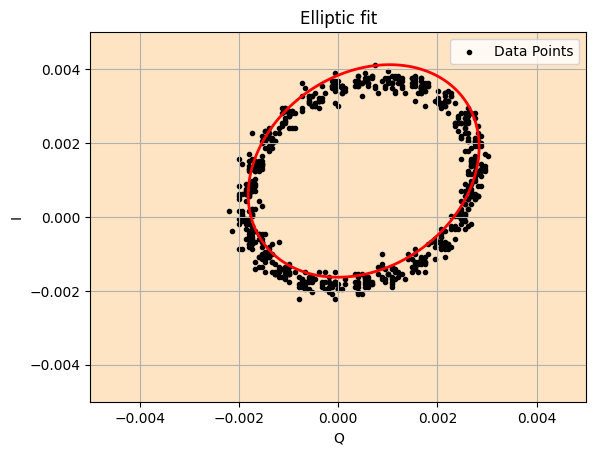

In [30]:
# Plot the least squares ellipse
y_coord = np.linspace(-0.005,0.005,len(I))
x_coord = np.linspace(-0.005,0.005,len(I))
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * (X_coord-center_coor['xc']) ** 2 + x[1] * (X_coord-center_coor['xc']) * (Y_coord-center_coor['yc'])+ x[2] * (Y_coord-center_coor['yc'])**2 + x[3] * (X_coord-center_coor['xc']) + x[4] * (Y_coord-center_coor['yc'])

fig, axs = plt.subplots(1,1)
axs.scatter(Q, I, label='Data Points', marker='.', color='black')
axs.set_facecolor('bisque')
axs.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)
axs.legend()
axs.set_title('Elliptic fit')
axs.set_xlabel('Q')
axs.set_ylabel('I')
axs.grid()